## Filter Selection for Galactic Plane Fields

The maps of desired fields within the Galactic Plane, Bulge and Magellanic Clouds (described in more detail in https://github.com/LSST-TVSSC/software_tools/blob/main/GalacticPlaneSurveyFootprint.ipynb) were designed to take into account the relative priority placed on observations in different filters by different science cases.  

This was done by assigning a weighting between 0-1 to each filter for each science case, and this was factored by the priority of the pointing for each HEALpix.  Votes were then summed over all science cases considered, to create a priority map in each filter. 

These filter-specific priority maps can be used in a metric to evaluate how well a given OpSim meets the filter requirements of the science in the following way. 

The proportion of observing time spent per filter can be calculated for each HEALpix as the total exposure time spent in each filter as a of the total exposure time dedicated to that HEALpix.  In the optimum survey strategy, these proportions per HEALpix should correspond to the relative priorities of that HEALpix in the priority maps for each filter.  

The proportion of observing time per filter can then be summed over all HEALpix within the desired Galactic Plane survey region and over all filters.  The final metric presents a this result as a percentage of that expected from the ideal survey strategy.

Metric code can be found at: https://github.com/LSST-TVSSC/software_tools/blob/main/TimePerFilterGalPlane.py

In [1]:
from os import getenv, path
import numpy as np
import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import science_priority_regions
import generate_galplane_priority_maps
from astropy_healpix import HEALPix
from astropy.coordinates import Galactic, TETE, SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
NSIDE=64

First, we load the Galactic Plane survey region priority maps:

In [3]:
footprint_maps_dir = getenv('FOOTPRINT_MAPS_DIR')
filter_order = ['u', 'g', 'r', 'i', 'z', 'y']
maps = [] # Map data is stored in filter order

for f in filter_order:
    m = hp.read_map(path.join(footprint_maps_dir,'GalPlane_priority_map_'+f+'.fits'), dtype=np.float64)
    maps.append(m)

In these maps, each HEALpixel value represents a priority weighting for that position in the sky, which is normalized across all filters.  The fraction of the priority/HEALpix in a given filter as a function of the total priority for that HEALpix (summed over all filters) gives us an approximate guide to the proportion of the total exposure time that should be allocated to each filter.  

In [29]:
coadded_map = np.zeros(maps[0].shape)
for i,f in enumerate(filter_order):
    coadded_map += maps[i]

fexpt_per_filter_per_pixel = np.zeros([len(maps[0]),len(filter_order)])
for i,f in enumerate(filter_order):
    valid = coadded_map > 0
    fexpt_per_filter_per_pixel[:,i] = maps[i] / coadded_map
invalid = np.isnan(fexpt_per_filter_per_pixel)
fexpt_per_filter_per_pixel[invalid] = 0.0

/var/folders/4z/rk7n9jss74g3shm9z6msmyvh0000gp/T/ipykernel_15593/3977200076.py:8: RuntimeWarning: invalid value encountered in true_divide
  fexpt_per_filter_per_pixel[:,i] = maps[i] / coadded_map


Map of the fraction of the total exposure time to be spent in SDSS-i exposures


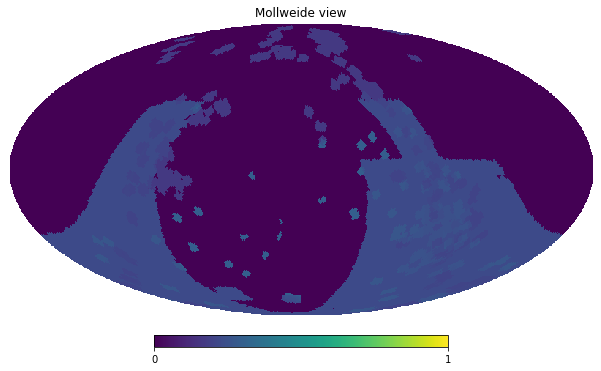

In [30]:
hp.mollview(fexpt_per_filter_per_pixel[:,3], max=1)
print('Map of the fraction of the total exposure time to be spent in SDSS-i exposures')

Maps such as the one above can be computed for any given OpSim strategy for comparison. 

For the purposes of Galactic and Magellanic Cloud science however, we are concerned only with the metric values for those pixels in the desired survey region.  Therefore the metric calculates for any OpSim dataSlice the fexpt_per_filter_per_pixel value only for pixels within the desired Galactic Plane survey footprint as defined by the maps above.  The metric returns a single numerical value for ease of handling, which is the fexpt_per_filter_per_pixel summed over all pixels within the desired footprint and over all filters.  This parameter is called fExpT.  

Lastly, to complete the metric, we need a normalizing value to use as a guide for the value of fExpT that would be expected if the OpSim represented an ideal survey strategy for galactic science; that is perfect overlap with the survey footprint with the recommended proportions of exposure time spent.  

This is estimated simply by calculating fexpt_per_filter_per_pixel from the priority maps above, and summing over all pixels and filters.  